In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# ─── USER PARAMETERS ───────────────────────────────────────────────────────────
training_offset     = 0
total_size          = 10000
sliding_window_size = 10    # encoder length
prediction_window   = 1
validation_duration = 3000  # length of validation window
test_duration       = 3000  # length of test window
batch_size          = 32
max_epochs          = 30
patience_val        = 7
base_folder         = "/content/drive/MyDrive/tft/"
model_save_folder   = base_folder + f"model-{sliding_window_size}-{prediction_window}-{total_size/1000}K"  # folder to save checkpoints
# ────────────────────────────────────────────────────────────────────────────────

# ensure save directory exists
os.makedirs(model_save_folder, exist_ok=True)

In [3]:
# install required packages (only need to run once)
!pip install pytorch-lightning pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, Callback, ModelCheckpoint
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

torch.set_float32_matmul_precision('medium')  # or 'high'

In [6]:
# load raw data
df = pd.read_csv(base_folder + "data/old/df_pca_n.csv").reset_index(drop=True)
df["time_idx"] = df.index
df["series"]   = "BTC"
pca_columns = [c for c in df.columns if c.startswith("pca")]

# build contiguous val and test from middle
train_df = df.iloc[training_offset:training_offset + total_size].copy()
val_df  = df.iloc[training_offset + total_size: training_offset + total_size + validation_duration].copy()
test_df = df.iloc[training_offset + total_size + validation_duration: training_offset + total_size + validation_duration + test_duration].copy()

target_normalizer = GroupNormalizer(
    groups=["series"],
    transformation="log",       # learn in log space, invert with exp
)

# helper to create dataset template
def create_dataset(df):
    return TimeSeriesDataSet(
        df,
        time_idx="time_idx",
        target="close",
        group_ids=["series"],
        min_encoder_length=sliding_window_size,
        max_encoder_length=sliding_window_size,
        min_prediction_length=prediction_window,
        max_prediction_length=prediction_window,
        static_categoricals=["series"],
        time_varying_known_reals=["time_idx"] + pca_columns,
        time_varying_unknown_reals=["close"],
        target_normalizer=target_normalizer,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True,
    )

In [7]:
# create dataset objects
train_dataset = create_dataset(train_df)
val_dataset   = TimeSeriesDataSet.from_dataset(
    train_dataset,
    val_df,
    predict=False,
    stop_randomization=True
)
test_dataset  = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_df,
    predict=False,
    stop_randomization=True
)

# create dataloaders
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=11)
val_dataloader   = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=11)
test_dataloader  = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=11)

In [8]:
# callback to record losses
class LossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_losses.append(trainer.callback_metrics["train_loss"].item())
    def on_validation_epoch_end(self, trainer, pl_module):
        if not trainer.sanity_checking:
            self.val_losses.append(trainer.callback_metrics["val_loss"].item())

loss_history = LossHistory()

# checkpoint callback to save best model
checkpoint_callback = ModelCheckpoint(
    dirpath=model_save_folder,
    filename="best_tft",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True
)

In [9]:
# build TFT model
quantiles=[0.1, 0.5, 0.9]
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=1e-3,
    hidden_size=32,
    attention_head_size=8,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=len(quantiles),
    loss=QuantileLoss(quantiles=quantiles),
)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [10]:
# trainer
trainer = Trainer(
    max_epochs=max_epochs,
    gradient_clip_val=0.1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=patience_val), loss_history, checkpoint_callback],
    enable_model_summary=False,
)

# train
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# optionally save final checkpoint
final_ckpt = os.path.join(model_save_folder, "final_tft.ckpt")
trainer.save_checkpoint(final_ckpt)
print(f"Best model: {checkpoint_callback.best_model_path}\nFinal model: {final_ckpt}")


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /content/drive/MyDrive/tft/model-10-1-10.0K exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best model: /content/drive/MyDrive/tft/model-10-1-10.0K/best_tft-v1.ckpt
Final model: /content/drive/MyDrive/tft/model-10-1-10.0K/final_tft.ckpt


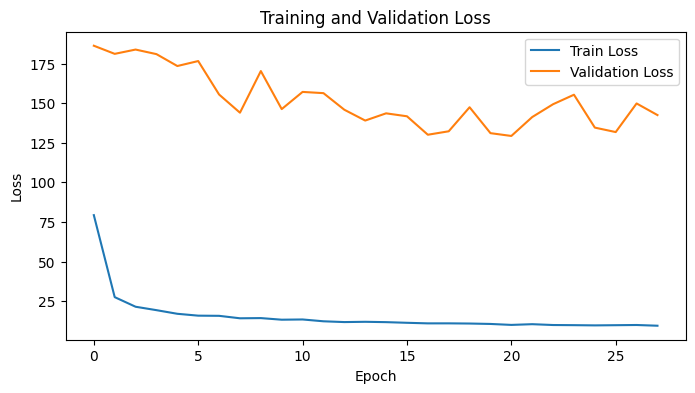

In [11]:
# plot losses
plt.figure(figsize=(8,4))
plt.plot(loss_history.train_losses, label="Train Loss")
plt.plot(loss_history.val_losses,   label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Training and Validation Loss"); plt.show()

In [12]:
def get_actuals_and_preds_multi(dataloader):
    # model.predict returns shape (num_samples, prediction_length, output_size)
    preds = tft.predict(dataloader).cpu().numpy()
    # if output_size == 1, squeeze that dimension
    if preds.ndim == 3 and preds.shape[2] == 1:
        preds = preds.squeeze(-1)  # now (num_samples, prediction_length)
    # actuals y[0] has shape (batch_size, prediction_length)
    actuals = np.concatenate([y[0].numpy() for x, y in iter(dataloader)], axis=0)
    return actuals, preds

In [13]:
# get results
train_pred_dataloader = train_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=11)
train_actual, train_pred = get_actuals_and_preds_multi(train_pred_dataloader)
val_actual,   val_pred   = get_actuals_and_preds_multi(val_dataloader)
test_actual,  test_pred  = get_actuals_and_preds_multi(test_dataloader)

# number of steps ahead
prediction_length = train_pred.shape[1]
# number of points to plot
n_points = 2000 if train_pred.shape[0] >= 2000 else train_pred.shape[0]

# function to plot each horizon
def plot_multi_step(actual, pred, dataset_name):
  for step in range(pred.shape[1]):
      plt.figure(figsize=(12, 4))
      plt.plot(actual[:n_points, step], label=f"Actual ({dataset_name}) {step+1}-step ahead")
      plt.plot(pred[:n_points, step],   label=f"Predicted ({dataset_name}) {step+1}-step ahead")
      print(f"{dataset_name} MSE: {np.mean((pred[:,step]-actual[:,step])**2):.4f}, MAE: {np.mean(np.abs(pred[:,step]-actual[:,step])):.4f}")
      plt.title(f"{dataset_name.capitalize()} Set: Actual vs Predicted {step+1}-step Ahead")
      plt.legend()
      plt.show()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 💡 Tip: For seamless cloud

train MSE: 84.4608, MAE: 6.3471


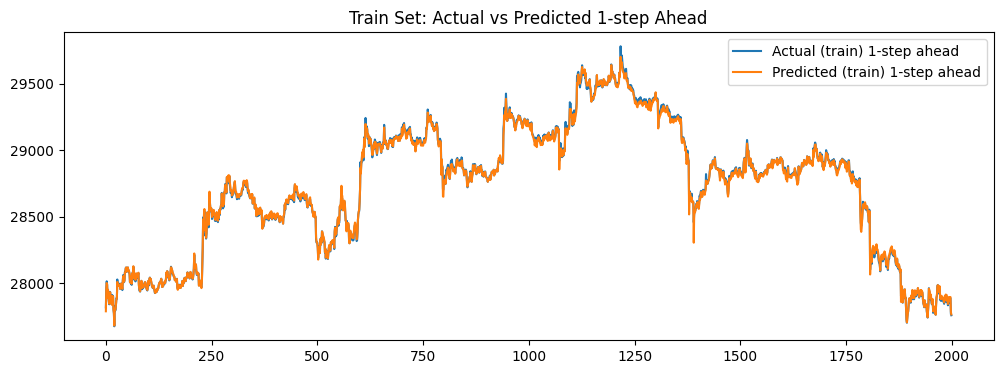

In [14]:
# plot for each split
plot_multi_step(train_actual, train_pred, "train")

validation MSE: 82320.6484, MAE: 157.6461


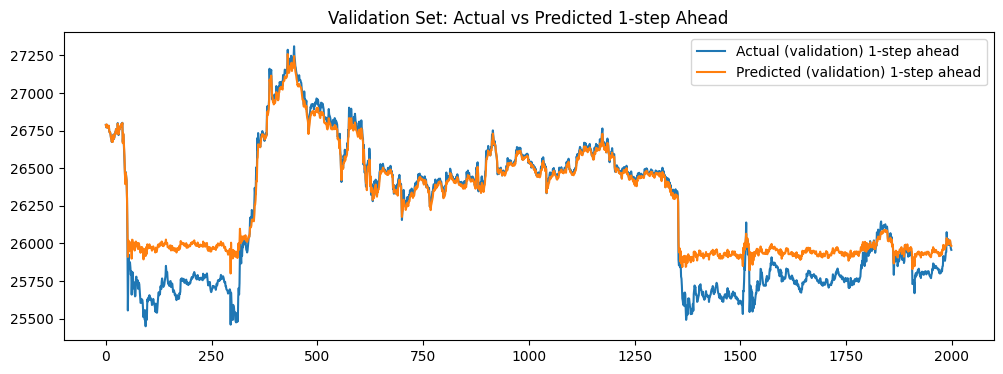

In [15]:
plot_multi_step(val_actual, val_pred, "validation")

test MSE: 359411.1875, MAE: 416.5782


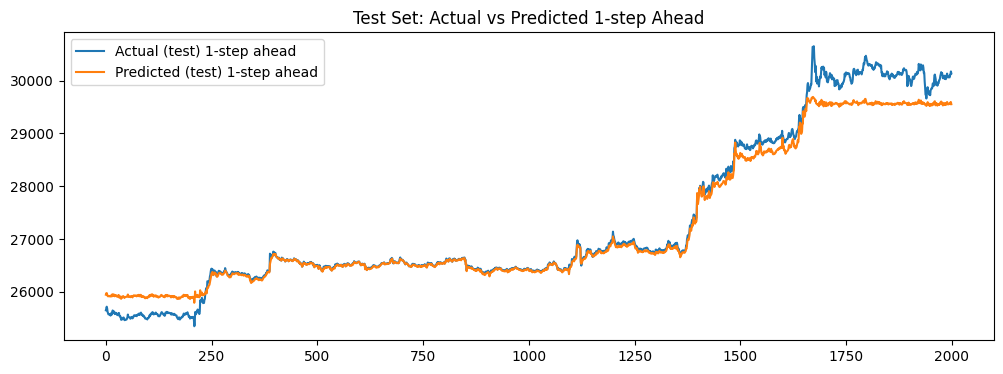

In [16]:
plot_multi_step(test_actual, test_pred, "test")

In [17]:
max(train_df['close'])

29780.02

In [18]:
min(train_df['close'])

25946.09